<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
pip install dtw-python

In [13]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from math import sqrt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import pandas as pd
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from dtw import *

In [14]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

In [15]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; NARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
def print_serie(serie_,title_,ytitle_,xtitle_,dot_,namefile_):
    fig, ax1 = plt.subplots(figsize=(7,4))
    plt.title(title_,fontsize='x-large',color=NARA)
    ax1.set_xlabel(xtitle_, color=NARA, fontsize='large')
    ax1.set_ylabel(ytitle_, color=NARA, fontsize='large')
    plt.tick_params(colors = NARA, which='both')
    ax1.spines['bottom'].set_color(NARA)
    ax1.spines['top'   ].set_color(NARA) 
    ax1.spines['right' ].set_color(NARA)
    ax1.spines['left'  ].set_color(NARA)    
    for p in serie_:
        if dot_== True:
           plt.plot(p,alpha=0.4, linestyle='dashed', linewidth=3)
        else:
           plt.plot(p,alpha=0.4)                
    plt.savefig(namefile_, transparent=True)         
    plt.show()

In [16]:
## Encuentra los vecinos más cercanos
def get_neighbors(train, test_row, num_neighbors, typedist='euclidean'):
  
    distances = list()

    for train_row in train:
        if typedist == 'dtw':
            dist = dtw(test_row, train_row)
        else:
            dist = euclidean(test_row, train_row)
        distances.append((train_row, dist))
    distances.sort(key=lambda tup: tup[1])

    neighbors = list()

    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors

## Calcula distancia euclidiana
def euclidean(neig1, neig2):
	  distance = 0.0
	  for i in range(len(neig1)):
		    distance += (neig1[i] - neig2[i])**2
	  return sqrt(distance)

In [17]:
#https://drive.google.com/drive/folders/1Gj3XK9kM-lE18uBMe3qrZOGEm8yAI8i9
#https://www.codegrepper.com/code-examples/python/how+to+read+csv+file+from+google+drive+on+google+colab+
path        = 'https://drive.google.com/uc?export=download&id=' 
URL_Demanda = 'https://drive.google.com/file/d/1xcpXDTE7H6EBMLOkic5lq-lzSwiLG2ZS/view?usp=sharing'
df_Demanda  = pd.read_csv(path + URL_Demanda .split('/')[-2], usecols=[0] ) #names=['CLVUNI','TYPE','NODE'], usecols=[1,2,3,4,5,6,], 1,2,3,4,5,6,7,8,9,10,11,12,13,15,
df_Demanda.dropna(inplace=True)
serie = df_Demanda.to_numpy()
serie = StandardScaler().fit_transform(serie)
serie = serie.ravel() ## Con esto quitamos el bracket o corchete en cada uno de loselementos del arreglo

In [30]:
def analogo_knn(serie,v,k=10,tol=0.8,typedist='euclidian',typereg='OLS'):    
#    v       : tamanio de la ventana
#    k       : número de vecinos a buscar k
#    tol     : tolerancia de tamaño de ventanas para seleccion de vecinos
#    typedist: medida de distancia, 'dtw' o 'euclidian' o 'pearson'

    t_o = time.time()
    n = len(serie) ## longitud total de la serie

    ## PASO 1: Selección de las ventanas de mayor correlación.

    ## Calculamos la distancia entre todos los vecinos.
    distances = []
    Y = serie[n-v:n]           ## últimos datos
    for i in range(n-2*v):
        if  typedist == 'dtw': ## dynamic time warping
            dist = dtw(Y, serie[i:i+v]).distance  
        elif typedist == 'pearson':
            dist = np.corrcoef(Y,serie[i:i+v])[1,0]
        else:
            dist = euclidean(Y,serie[i:i+v])
        if dist > 0:
            distances.append((i, dist))
        
    ## Calculamos el vecindario por distancia de menor a mayor y se guardan las posiciones.
    if typedist == 'pearson':
        ## En caso de pearson se ordena al revés, nos interesan los mayor correlación.
        distances.sort(key=lambda tup: tup[1], reverse=True)
    else:
        ## En caso de pearson se ordena al revés, nos interesan los de menor distancia.
        distances.sort(key=lambda tup: tup[1], reverse=False)

    neighbors  = []
    neighbors2 = []
    positions  = []

    ## Calculamos los k vecinos mas cercanos y guardamos las posiciones.
    i = 0
    for pos, dis in distances:
        if i==0:      
            positions.append(pos)   
            neighbors.append(serie[pos:pos+v])
            neighbors2.append(serie[pos+v:pos+2*v])
        else:
            bandera = True
            for p in positions:
                 ## si ya teniamos una posición en la lista que pase la tolerancia, ya no guardamos 
                if (abs(pos - p) < tol*v):
                    bandera = False
                    i = i - 1
                    break
            if bandera == True:
                ## Guarda nuevo vecino
                positions.append(pos)   
                neighbors.append(serie[pos:pos+v])
                neighbors2.append(serie[pos+v:pos+2*v])
                bandera = False
        i = i + 1
        if i == k:
            break
    #print('positions KNN:',positions)    ## posición de los k vecinos mas cercanos

    ## Convertimos a numpy
    neighbors  = np.array(neighbors)
    neighbors2 = np.array(neighbors2)

    print_serie(neighbors, 'KNN - X         ','demanda','time', False,'fig_1')
    print_serie(neighbors2,'KNN - X2 (prima)','demanda','time', False,'fig_2')

    t_sel = time.time() - t_o

    ## PASO 2: Regresión entre los vecinos mas cercanos 'X' y la última ventana 'Y'

    ## Definimos nuestros regresores 
    X   = (neighbors.T).tolist()
    X_2 = (neighbors2.T).tolist()
    Y   = (Y).tolist()

    ## Regresión -- OLS with Stepwise --
    if typereg == 'OLS':
        model   = sm.OLS(Y, X)
        results = model.fit()
        result_prediction = results.predict(X_2)

        ## Ordenamos los valores 'pi' y se selecciona el más grande.
        i = 0
        pvalues = []
        for pi in results.pvalues:
            pvalues.append((i,pi))
            i = i + 1
        pvalues.sort(key=lambda tup: tup[1], reverse=True) ## Ordenamos por 'pi'
        (i, pi) = pvalues[0]  

        while pi > 0.05:
            X   = sm.add_constant(X)
            X_2 = sm.add_constant(X_2) 
            #print('Retiramos regresor X' + str(i))
            X   = np.delete(arr=X,   obj=i+0, axis=1)
            X_2 = np.delete(arr=X_2, obj=i+0, axis=1)   
            model   = sm.OLS(Y, X)
            results = model.fit()

            ## Ordenamos los valores 'pi' y se selecciona el más grande
            i = 0
            pvalues = []
            for pi in results.pvalues:
                pvalues.append((i,pi))
                i = i + 1
            pvalues.sort(key=lambda tup: tup[1], reverse=True) ## Ordenamos por 'pi'
            (i, pi) = pvalues[0]
            #prediction   = results.predict(X)   ## Ajuste
            prediction_Y2 = results.predict(X_2) ## Pronóstico
        print(results.summary())

    ## Voting regression 
    ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html#sphx-glr-auto-examples-ensemble-plot-voting-regressor-py
    if typereg == 'Voting':
        reg1 = GradientBoostingRegressor(random_state=1)
        reg2 = RandomForestRegressor(random_state=1)
        reg3 = LinearRegression()
        reg1.fit(X, Y)
        reg2.fit(X, Y)
        reg3.fit(X, Y)
        ereg = VotingRegressor([("gb", reg1), ("rf", reg2), ("lr", reg3)])
        ereg.fit(X, Y)
        prediction_Y2 = ereg.predict(X_2)

    ## Regresión -- Random Forrest Regression --
    ## https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
    if typereg == 'RF':
        model         = RandomForestRegressor(n_estimators=500, random_state=42, max_depth = 30, bootstrap=False)
        #model         = RandomForestRegressor()
        results       = model.fit(X, Y)
        prediction_Y2 = results.predict(X_2)

        ## Preparamos la información para graficar la importancia y las posiciones en Random Forest Regressor
        if 1==1:
            i=0
            labels = [str(x) for x in positions]
            labels_importances = []
            for feat in model.feature_importances_:
                labels_importances.append((feat,labels[i]))
                i=i+1   
            labels_importances.sort(key=lambda tup: tup[0], reverse=False)
            importances = []
            labels      = []
            for tup in labels_importances:
                importances.append(tup[0])
                labels.append(tup[1])

            y_pos = np.arange(len(importances))

            fig, ax = plt.subplots()
            ax.barh(y_pos, importances, align='center')
            ax.set_yticks(y_pos)
            ax.invert_yaxis()
            ax.set_xlabel('Importancia')
            ax.set_ylabel('Variable')
            ax.set_title( 'Importancia de las variables')
            plt.show()

    t_reg = time.time() - t_sel  - t_o

    return prediction_Y2, t_sel, t_reg

---

## Probamos el modelo con 'pearson' y 'RF'.



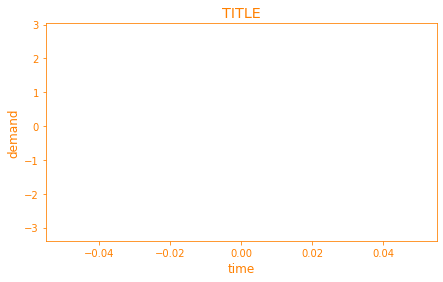

In [33]:
## Parámetros de prueba.
v = 288; k = 20 ; tol = 0.8
dias = 5
false_end = dias * v ## Usa dias*v como número de dias hacia atrás para hacer pruebas de dos ventanas hacia atras
print_serie(serie_=np.array(serie), title_='TITLE',ytitle_='demand',xtitle_='time', dot_=False,namefile_='fig_1')

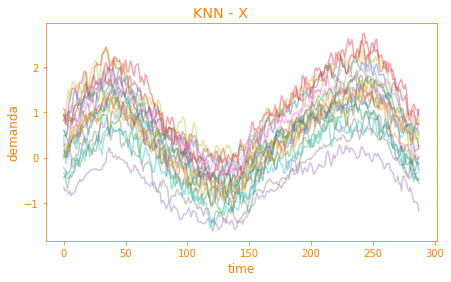

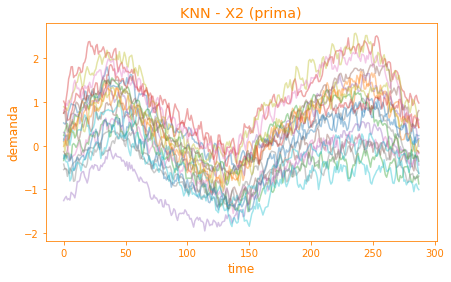

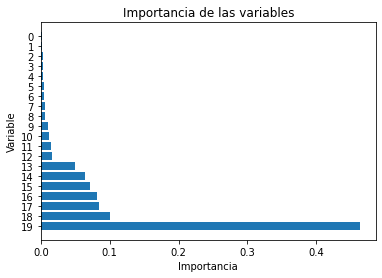

In [19]:
if 1==1:
    x_train = serie[0 : len(serie) - false_end]
    y_test  = serie[len(serie) - false_end : len(serie) - false_end + v]
    pred_pea_rf, t_sel_pea_rf, t_reg_pea_rf = analogo_knn(x_train,v=v,k=k,tol=tol,typedist='pearson',typereg='RF')

    # Exactitud del modelo
    mae_pea_rf  = mean_absolute_error(y_test,pred_pea_rf)
    mape_pea_rf = mean_absolute_percentage_error(y_test,pred_pea_rf)

---
## Probamos el modelo con 'pearson' y 'OLS'.

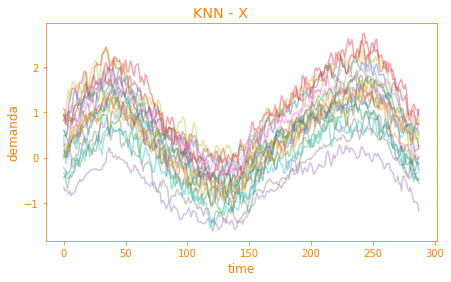

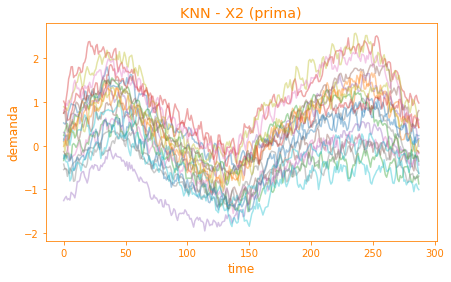

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     841.5
Date:                Sun, 08 May 2022   Prob (F-statistic):          9.93e-156
Time:                        19:39:45   Log-Likelihood:                 74.811
No. Observations:                 288   AIC:                            -139.6
Df Residuals:                     283   BIC:                            -121.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3063      0.050      6.121      0.0

In [20]:
if 1==1:
    x_train = serie[0 : len(serie) - false_end]
    y_test  = serie[len(serie) - false_end : len(serie) - false_end + v]
    pred_pea_ols, t_sel_pea_ols, t_reg_pea_ols = analogo_knn(x_train,v=v,k=k,tol=tol,typedist='pearson',typereg='OLS')

    # Exactitud del modelo
    mae_pea_ols  = mean_absolute_error(y_test,pred_pea_ols)    
    mape_pea_ols = mean_absolute_percentage_error(y_test,pred_pea_ols)

---

## Probamos el modelo con 'pearson' y 'Voting'.

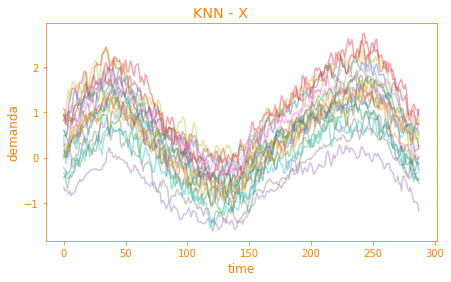

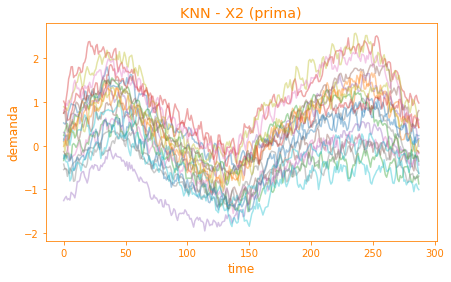

In [21]:
if 1==1:
    x_train = serie[0 : len(serie) - false_end]
    y_test  = serie[len(serie) - false_end : len(serie) - false_end + v]
    pred_pea_vot, t_sel_pea_vot, t_reg_pea_vot = analogo_knn(x_train,v=v,k=k,tol=tol,typedist='pearson',typereg='Voting')

    # Exactitud del modelo
    mae_pea_vot = mean_absolute_error(y_test,pred_pea_vot)
    mape_pea_vot = mean_absolute_percentage_error(y_test,pred_pea_vot)



---



## Probamos el modelo con 'euclidian' y 'OLS' 

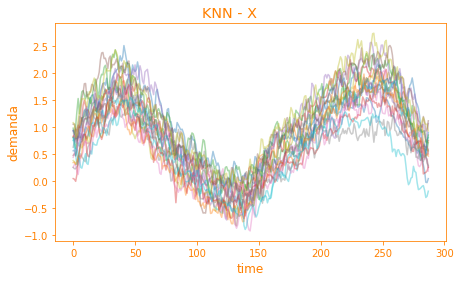

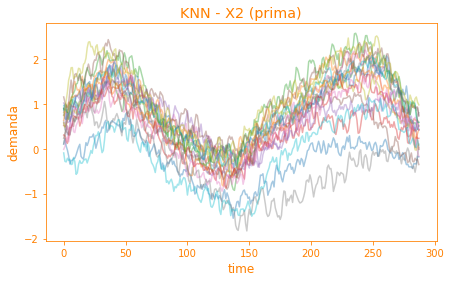

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.974
Method:                 Least Squares   F-statistic:                              1345.
Date:                Sun, 08 May 2022   Prob (F-statistic):                   1.69e-218
Time:                        19:40:16   Log-Likelihood:                          85.110
No. Observations:                 288   AIC:                                     -154.2
Df Residuals:                     280   BIC:                                     -124.9
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [22]:
if 1==1:
    x_train = serie[0 : len(serie) - false_end]
    y_test  = serie[len(serie) - false_end : len(serie) - false_end + v]
    pred_euc_ols, t_sel_euc_ols, t_reg_euc_ols = analogo_knn(x_train,v=v,k=k,tol=tol,typedist='euclidian',typereg='OLS')

    # Exactitud del modelo
    mae_euc_ols  = mean_absolute_error(y_test,pred_euc_ols)
    mape_euc_ols = mean_absolute_percentage_error(y_test,pred_euc_ols)

---

## Probamos el modelo con 'euclidian' y 'RF'.



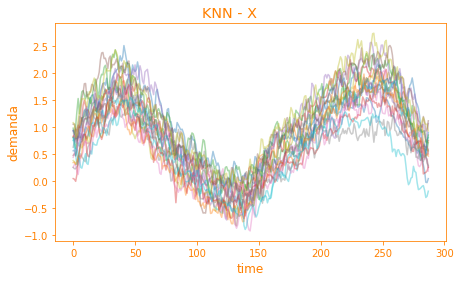

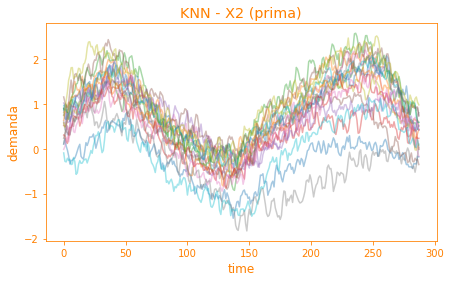

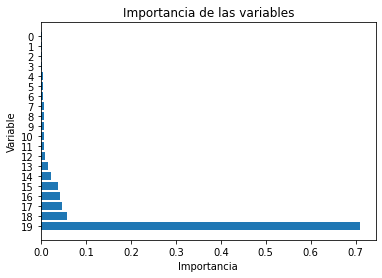

In [23]:
if 1==1:
    x_train = serie[0 : len(serie) - false_end]
    y_test  = serie[len(serie) - false_end : len(serie) - false_end + v]
    pred_euc_rf, t_sel_euc_rf, t_reg_euc_rf = analogo_knn(x_train,v=v,k=k,tol=tol,typedist='euclidian',typereg='RF')

    # Exactitud del modelo
    mae_euc_rf  = mean_absolute_error(y_test,pred_euc_rf)
    mape_euc_rf = mean_absolute_percentage_error(y_test,pred_euc_rf)

---

## Probamos el modelo con 'dtw' y 'OLS'.

In [24]:
if 1==0:
    x_train = serie[0 : len(serie) - false_end]
    y_test  = serie[len(serie) - false_end : len(serie) - false_end + v]
    pred_dtw_ols, t_sel_dtw_ols, t_reg_dtw_ols = analogo_knn(x_train,v=v,k=k,tol=tol,typedist='dtw',typereg='OLS')

    # Exactitud del modelo
    mae_dtw_ols  = mean_absolute_error(y_test,pred_dtw_ols)
    mape_dtw_ols = mean_absolute_percentage_error(y_test,pred_dtw_ols)

---

## Probamos el modelo con 'dtw' y 'RF'.

In [25]:
if 1==0:
    x_train = serie[0 : len(serie) - false_end]
    y_test  = serie[len(serie) - false_end : len(serie) - false_end + v]
    pred_dtw_rf, t_sel_dtw_rf, t_reg_dtw_rf = analogo_knn(x_train,v=v,k=k,tol=tol,typedist='dtw',typereg='RF')

    # Exactitud del modelo
    mae_dtw_rf  = mean_absolute_error(y_test,pred_dtw_rf)
    mape_dtw_rf = mean_absolute_percentage_error(y_test,pred_dtw_rf)

---

## Comparamos graficamente los resultados



In [26]:
print('| SELECCIÓN      | REGRESIÓN      | MAE             | MAPE             | TIEMPO SELECCIÓN     | TIEMPO REGRESIÓN   |')
print('| :------------- | :------------- | -------------:  | -------------:   |-------------:        |-------------:        |')
print('| PEARSON        | OLS + STEP     |',str(trunc(mae_pea_ols,4)),'         |',str(trunc(mape_pea_ols,4)),'         |',str(trunc(t_sel_pea_ols,4)),'              |   ',str(trunc(t_reg_pea_ols,4)),     '|')
print('| EUCLIDIAN      | OLS + STEP     |',str(trunc(mae_euc_ols,4)),'          |',str(trunc(mape_euc_ols,4)),'           |',str(trunc(t_sel_euc_ols,4)),'             |   ',str(trunc(t_reg_euc_ols,4)),    '|')
#print('| DTW            | OLS + STEP     |',str(trunc(mae_dtw_ols,4)),'         |',str(trunc(mape_dtw_ols,4)),'         |',str(trunc(t_sel_dtw_ols,4)),'            |   ',str(trunc(t_reg_dtw_ols,4)),    '|')
print('| PEARSON        | RF             |',str(trunc(mae_pea_rf,4)),'         |',str(trunc(mape_pea_rf,4)),'          |',str(trunc(t_sel_pea_rf,4)),'              |   ',str(trunc(t_reg_pea_rf,4)),    '|')
print('| EUCLIDIAN      | RF             |',str(trunc(mae_euc_rf,4)),'          |',str(trunc(mape_euc_rf,4)),'         |',str(trunc(t_sel_euc_rf,4)),'              |   ',str(trunc(t_reg_euc_rf,4)),     ' |')
#print('| DTW            | RF             |',str(trunc(mae_dtw_rf,4)),'         |',str(trunc(mape_dtw_rf,4)),'          |',str(trunc(t_sel_dtw_rf,4)),'            |   ',str(trunc(t_reg_dtw_rf,4)),    '|')
print('| PEARSON        | Voting         |',str(trunc(mae_pea_vot,4)),'         |',str(trunc(mape_pea_vot,4)),'         |',str(trunc(t_sel_pea_vot,4)),'            |   ',str(trunc(t_reg_pea_vot,4)),    '|')

| SELECCIÓN      | REGRESIÓN      | MAE             | MAPE             | TIEMPO SELECCIÓN     | TIEMPO REGRESIÓN   |
| :------------- | :------------- | -------------:  | -------------:   |-------------:        |-------------:        |
| PEARSON        | OLS + STEP     | 0.3404          | 2.5837          | 8.5713               |    0.1292 |
| EUCLIDIAN      | OLS + STEP     | 0.551           | 4.28            | 13.7946              |    0.0753 |
| PEARSON        | RF             | 0.2928          | 1.7881           | 3.9353               |    4.3991 |
| EUCLIDIAN      | RF             | 0.266           | 1.1927          | 9.5531               |    1.833  |
| PEARSON        | Voting         | 0.3034          | 2.1834          | 13.6952             |    3.7277 |


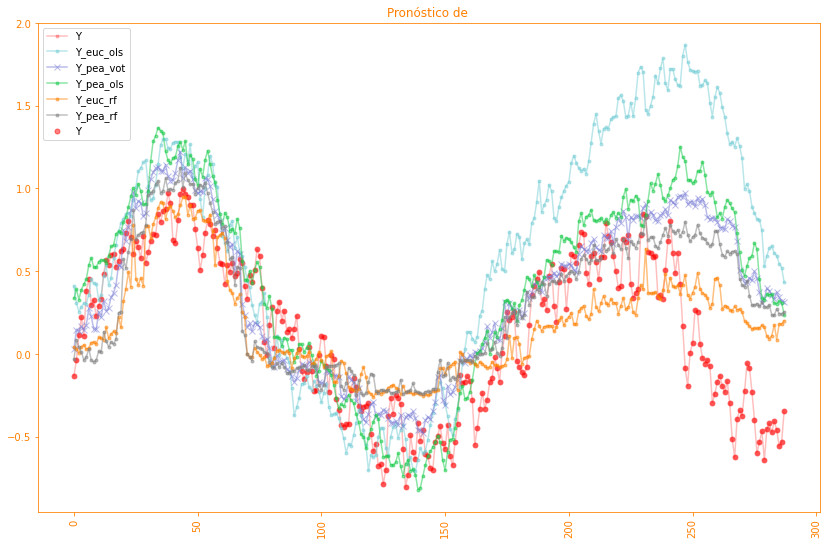

In [27]:
fig  = plt.figure(figsize=(14,9))
axes = fig.add_subplot(1, 1, 1)
axes.legend()
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; NARA ='#ff8000'; AZUL='#168fff'; GRIS = '#808080'
mytitle = plt.title('Pronóstico de ') # get the title property handler #plt.getp(title_obj)
plt.setp(mytitle,    color=LETRASNARA) #set the color of title to red
axes.xaxis.label.set_color(LETRASNARA)
axes.yaxis.label.set_color(LETRASNARA)
axes.tick_params(colors=LETRASNARA, which='both')

AUX = np.arange( len(y_test) )
plt.scatter ( AUX, y_test, s=25,marker='o', color = 'red', label = 'Y', alpha=1/2)
axes.plot   ( y_test ,      '.-', color = 'red' , label = 'Y',         alpha=1/4)
axes.plot   ( pred_euc_ols, '.-', color = CYAN  , label = 'Y_euc_ols', alpha=1/2)
#axes.plot   ( pred_dtw_ols, '.-', color = LILA  , label = 'Y_dtw_ols', alpha=1/2)
axes.plot   ( pred_pea_vot, '.-', color = LILA  , marker='x', label = 'Y_pea_vot', alpha=1/2)
axes.plot   ( pred_pea_ols, '.-', color = VERDE , label = 'Y_pea_ols', alpha=1/2)
axes.plot   ( pred_euc_rf, '.-',  color = NARA  , label = 'Y_euc_rf', alpha=1/2)
#axes.plot   ( pred_dtw_rf, '.-',  color = AZUL  , label = 'Y_dtw_rf', alpha=1/2)
axes.plot   ( pred_pea_rf,  '.-', color = GRIS  , label = 'Y_pea_rf' , alpha=1/2)
#axes.plot  ( xspline[3], yspline[3] , '.-'  , color = VERDE   , label = 'orden=4'  ,alpha=1/2)
#plt.scatter( dfx_miss, dfy_miss, marker='x',  s=170 ,  color = 'red' , label = 'perdidos' ,alpha=1)

#plt.axis([0,  600, 7650, 9800])
#plt.axis([100,  200, 7650, 9500])
#plt.axis([400,  500, 7450, 9500])
#plt.axis([-2,  100, 8100, 9600])
#plt.axis([300, 400, 7900, 9500])

axes.spines['bottom'].set_color(LETRASNARA)
axes.spines['top'   ].set_color(LETRASNARA) 
axes.spines['right' ].set_color(LETRASNARA)
axes.spines['left'  ].set_color(LETRASNARA)
plt.legend()  
plt.xticks(rotation=90)
plt.savefig('fig_t15_ajuste_prono.png', transparent=True)
plt.show()